# Group 25 Project Proposal: Heart Disease

## Introduction

In our project, we are going to use a dataset from the article (Detrano et al, 1989) used for training a model estimating probabilities of angiographic coronary disease. Using this dataset, we will try to answer this question: What set/combination of variable values will best determine/predict that a person will most likely have a heart disease?

The dataset `processed.cleveland.data` has 14 variables, of which 13 are predictors and 1 is for classes. 

In [171]:
library(repr)
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(RColorBrewer)

`age`: age in years

`sex`: sex (1 = male; 0 = female)

`cp`: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic

`trestbps`: resting blood pressure (in mm Hg on admission to the hospital)

`chol`: serum cholestoral in mg/dl

`fbs`: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)

`restecg`: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

`thalach`: maximum heart rate achieved

`exang`: exercise induced angina (1 = yes; 0 = no)

`oldpeak` = ST depression induced by exercise relative to rest

`slope`: the slope of the peak exercise ST segment -- Value 1: upsloping -- Value 2: flat -- Value 3: downsloping

`ca`: number of major vessels (0-3) colored by flourosopy

`thal`: 3 = normal; 6 = fixed defect; 7 = reversable defect

`num`: diagnosis of heart disease (angiographic disease status) -- Value 0: < 50% diameter narrowing (Normal)-- Value 1: > 50% diameter narrowing (Abnormal)

In [172]:
#Demonstration that the dataset can be read from the web into R and cleaning and wrangling our data into a tidy format.
H_D_cleveland <- read_csv("https://raw.githubusercontent.com/TimWei12/Group_25_project/main/processed.cleveland.data",
                          col_names=c("age", "sex", "cp","trestbps", "chol", "fbs", "restecg","thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
    # filter(ca != "?" & thal != "?") |>
    filter(num == 1 | num == 0) |>
    mutate(num = as.factor(num), ca = as.double(ca), thal = as.double(thal)) |>
    mutate(num = fct_recode(num, "Normal" = "0", "Abnormal" = "1"))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = as.double(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


In [173]:
set.seed(3456)
#split the dataset into the training dataset and testing dataset
cleveland_split <- initial_split(H_D_cleveland, prop = 0.75, strata = num)  
cleveland_train <- training(cleveland_split)   
cleveland_test <- testing(cleveland_split)

In [174]:
#Finding max value of each column
cleveland_max <- cleveland_train |>
    select(-num) |>
    map_dfc(max, na.rm =TRUE)

In [175]:
#Finding mean value of each column
cleveland_mean <- cleveland_train |>
    select(-num) |>
    map_dfc(mean, na.rm =TRUE)

In [176]:
#Finding min value of each column
cleveland_min <- cleveland_train |>
    select(-num) |>
    map_dfc(min, na.rm =TRUE)

In [177]:
#Merging tables into one
cleveland_sum <- bind_rows(cleveland_max, cleveland_min, cleveland_mean) |>
    add_column(summary = c("max", "min", "mean"), .before= "age")
cleveland_sum
#Summary table
summary(cleveland_train)

summary,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
max,76.00000,1.0000000,4.00000,180.0000,564.0000,1.0000000,2.0000000,202.0000,1.0000000,3.6000000,3.000000,3.0000000,7.000000
min,29.00000,0.0000000,1.00000,94.0000,149.0000,0.0000000,0.0000000,88.0000,0.0000000,0.0000000,1.000000,0.0000000,3.000000
mean,52.77439,0.6219512,2.95122,129.5366,242.2988,0.1158537,0.8719512,154.8476,0.2256098,0.7091463,1.463415,0.4099379,4.164634


      age             sex              cp           trestbps    
 Min.   :29.00   Min.   :0.000   Min.   :1.000   Min.   : 94.0  
 1st Qu.:45.00   1st Qu.:0.000   1st Qu.:2.000   1st Qu.:120.0  
 Median :52.00   Median :1.000   Median :3.000   Median :130.0  
 Mean   :52.77   Mean   :0.622   Mean   :2.951   Mean   :129.5  
 3rd Qu.:60.00   3rd Qu.:1.000   3rd Qu.:4.000   3rd Qu.:140.0  
 Max.   :76.00   Max.   :1.000   Max.   :4.000   Max.   :180.0  
                                                                
      chol            fbs            restecg         thalach     
 Min.   :149.0   Min.   :0.0000   Min.   :0.000   Min.   : 88.0  
 1st Qu.:207.8   1st Qu.:0.0000   1st Qu.:0.000   1st Qu.:143.0  
 Median :234.0   Median :0.0000   Median :0.000   Median :158.5  
 Mean   :242.3   Mean   :0.1159   Mean   :0.872   Mean   :154.8  
 3rd Qu.:267.2   3rd Qu.:0.0000   3rd Qu.:2.000   3rd Qu.:170.0  
 Max.   :564.0   Max.   :1.0000   Max.   :2.000   Max.   :202.0  
                  

In [178]:
#count for the NA
#Finding missing value of each column, provided that only columns “ca” and “thal” have missing values
count_NA <- cleveland_train |> 
    filter(is.na(ca)|is.na(thal)) |>
    count()
count_NA

n
<int>
3


In [179]:
#Finding number of observations in each class
count_obs <- cleveland_train |>
    group_by (num) |> 
    count()
count_obs

num,n
<fct>,<int>
Normal,123
Abnormal,41


The following box plots are used to compare the range (min, max, mean) of the variables, which is split by our class variable (i.e. normal or abnormal). The graphs can be used to initially visualize which variables can connect to a visible change between the classes.

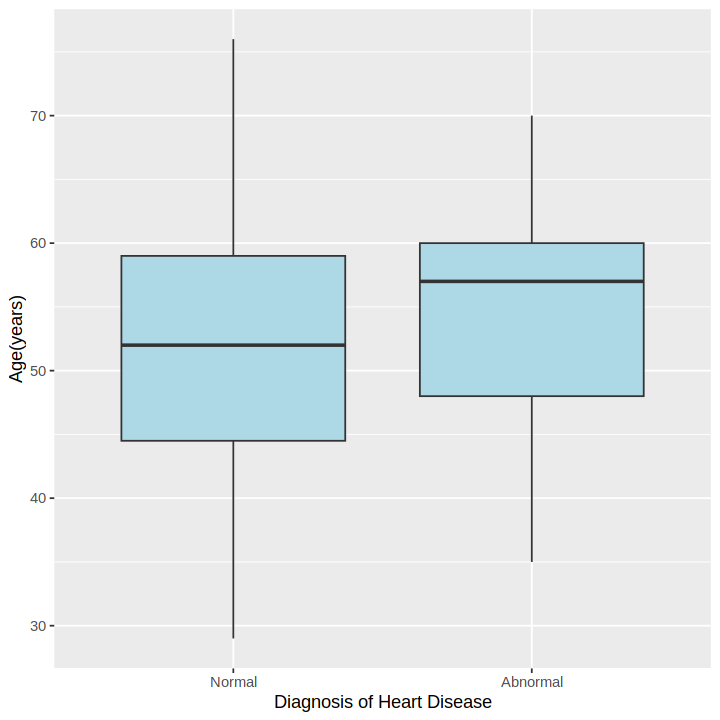

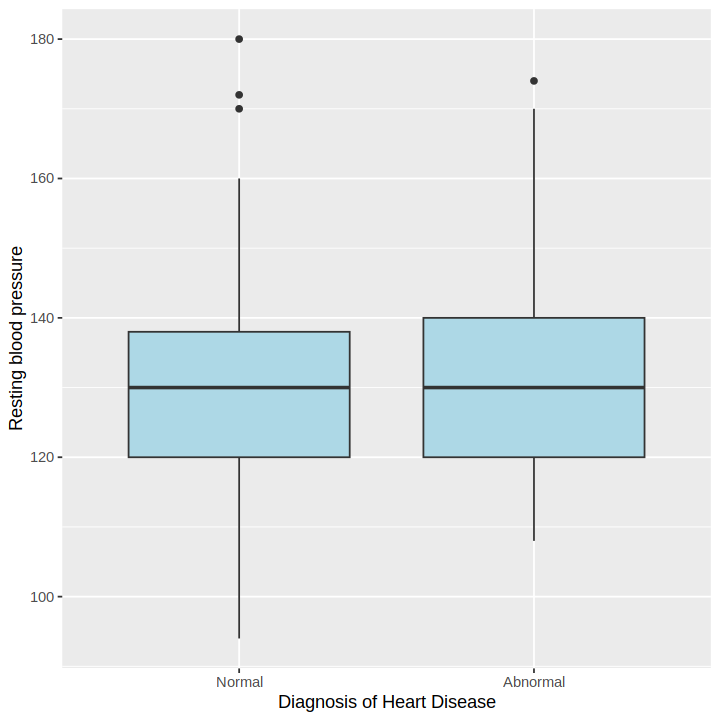

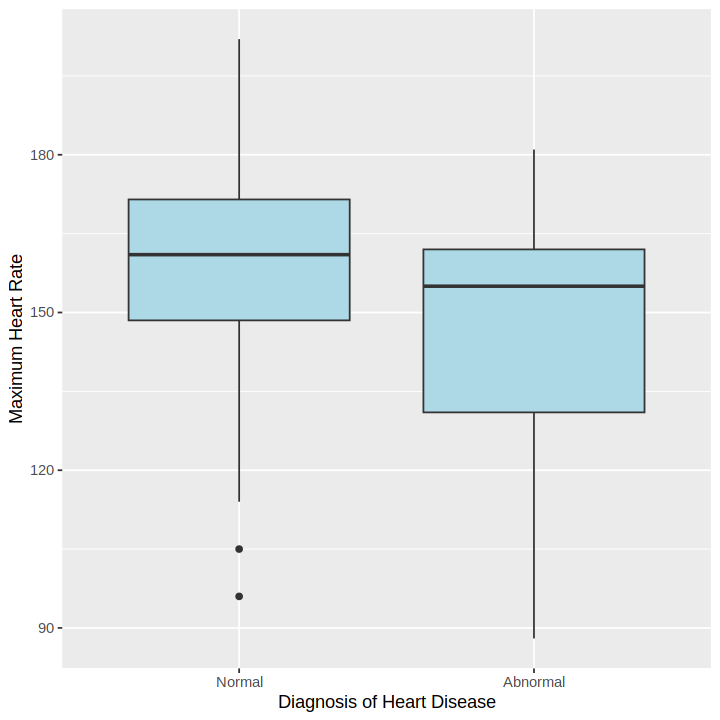

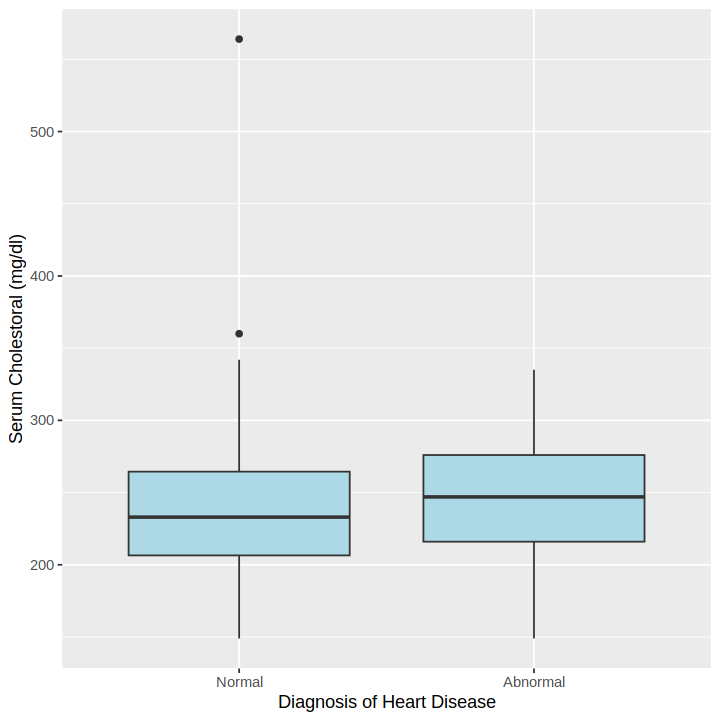

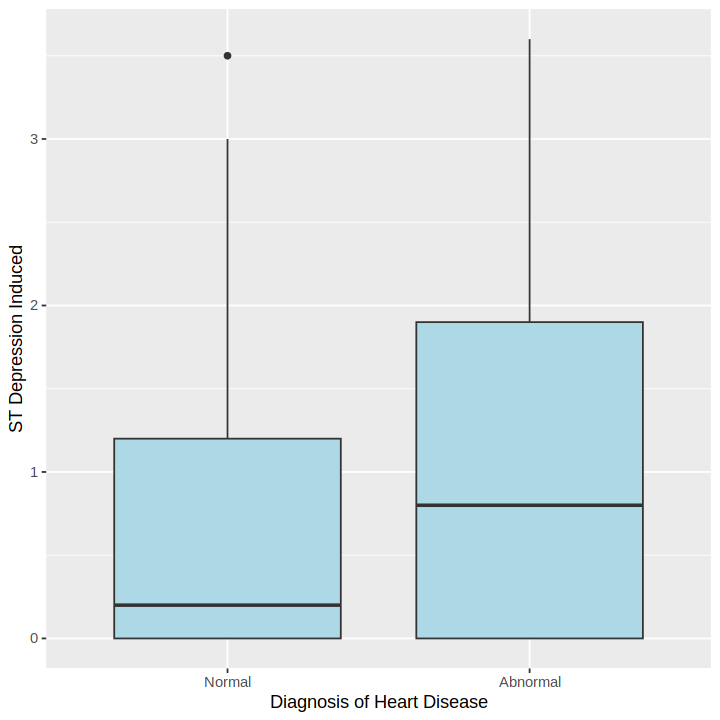

In [180]:
options (repr.plot.width = 6, repr.plot.height = 6)
#Plot varaiables vs. predictor using box plot
box_plot_age <- cleveland_train |> 
    ggplot(aes(x=num, y=age)) +
    geom_boxplot(fill="lightblue") + 
    labs(x= "Diagnosis of Heart Disease", y= "Age(years)") 

box_plot_restbps <- cleveland_train |> 
    ggplot(aes(x=num, y=trestbps))+
    geom_boxplot(fill="lightblue") + 
    labs(x= "Diagnosis of Heart Disease", y= "Resting blood pressure") 

box_plot_thalach <- cleveland_train |> 
    ggplot(aes(x=num, y=thalach))+
    geom_boxplot(fill="lightblue") + 
    labs(x= "Diagnosis of Heart Disease", y= "Maximum Heart Rate") 

box_plot_chol <- cleveland_train |> 
    ggplot(aes(x=num, y=chol))+
    geom_boxplot(fill="lightblue") + 
    labs(x= "Diagnosis of Heart Disease", y= "Serum Cholestoral (mg/dl)") 

box_plot_oldpeak <- cleveland_train |> 
    ggplot(aes(x=num, y=oldpeak))+
    geom_boxplot(fill="lightblue") + 
    labs(x= "Diagnosis of Heart Disease", y= "ST Depression Induced") 

box_plot_age
box_plot_restbps
box_plot_thalach
box_plot_chol
box_plot_oldpeak

The following scatterplots are used to show a comparison between two different variables, with each point being categorically coloured based off of our class variable(diagnosis/num: abnormal vs normal)

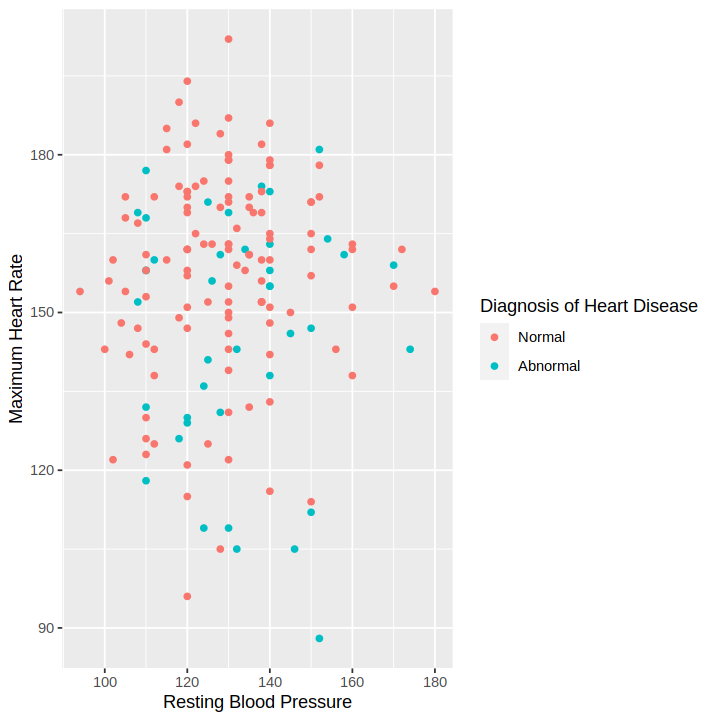

In [181]:
#PLot the Resting Blood Pressure vs. Maximum Heart Rate using scatter plot
diagnosis_plot_1 <- cleveland_train |>
    ggplot(aes(x=trestbps, y=thalach, color=num)) +
    geom_point() +
    labs(x = "Resting Blood Pressure", y = "Maximum Heart Rate", color = "Diagnosis of Heart Disease") +
    scale_fill_distiller(palette="Spectral")
diagnosis_plot_1

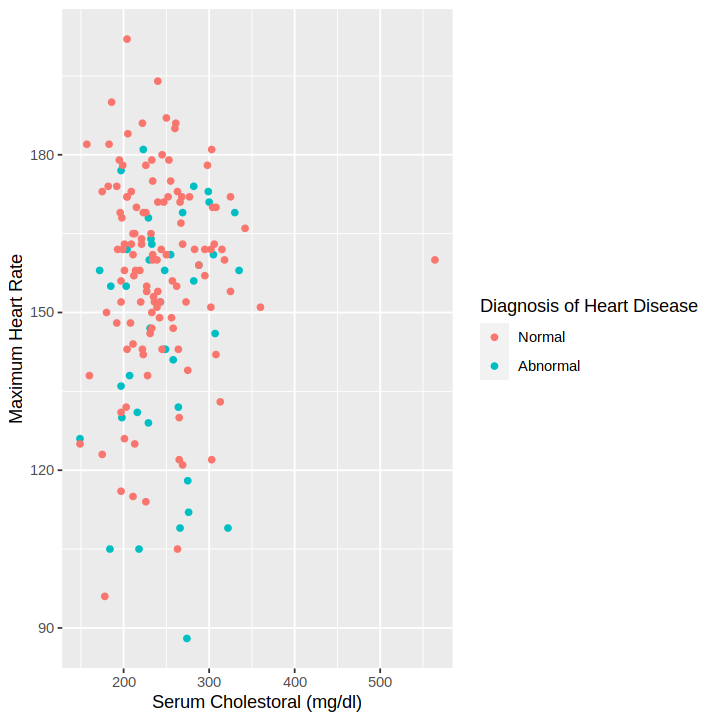

In [182]:
#PLot the Serum Cholestoral (mg/dl) vs. Maximum Heart Rate using scatter plot
diagnosis_plot_2 <- cleveland_train |>
    ggplot(aes(x=chol, y=thalach, color=num)) +
    geom_point() +
    labs(x = "Serum Cholestoral (mg/dl)", y = "Maximum Heart Rate", color = "Diagnosis of Heart Disease") +
    scale_fill_distiller(palette="Spectral")
diagnosis_plot_2

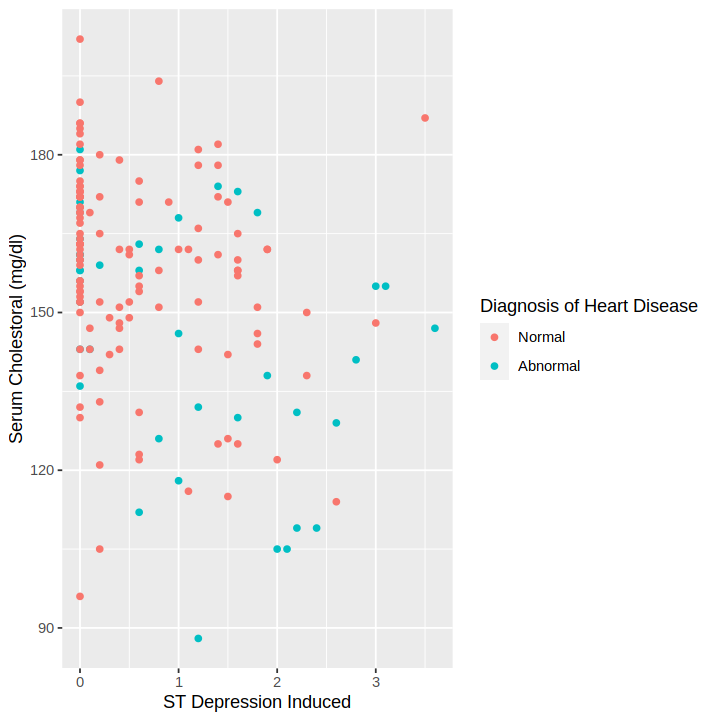

In [183]:
#PLot the ST Depression Induced vs. Serum Cholestoral (mg/dl) using scatter plot
diagnosis_plot_3 <- cleveland_train |>
    ggplot(aes(x=oldpeak, y=thalach, color=num)) +
    geom_point() +
    labs(x = "ST Depression Induced", y = "Serum Cholestoral (mg/dl)", color = "Diagnosis of Heart Disease") +
    scale_fill_distiller(palette="Spectral")
diagnosis_plot_3

In [184]:
#scale the dataset
cleveland_recipe <- recipe(num ~ ., data = cleveland_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())
cleveland_scaled <- cleveland_recipe |>
                            prep() |> 
                            bake(cleveland_train)

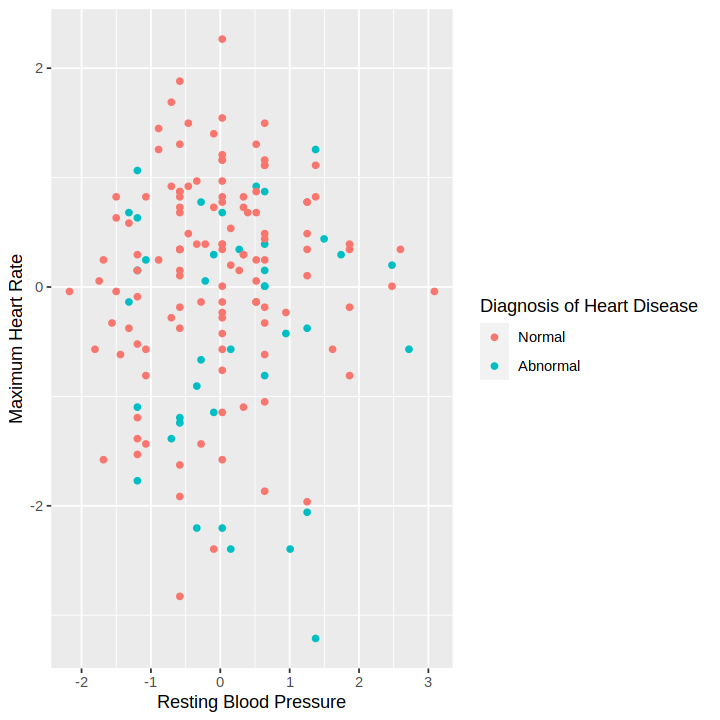

In [185]:
#PLot the Resting Blood Pressure vs. Maximum Heart Rate using scatter plot after scale
diagnosis_plot_s1 <- cleveland_scaled |>
    ggplot(aes(x=trestbps, y=thalach, color=num)) +
    geom_point() +
    labs(x = "Resting Blood Pressure", y = "Maximum Heart Rate", color = "Diagnosis of Heart Disease") +
    scale_fill_distiller(palette="Spectral")
diagnosis_plot_s1

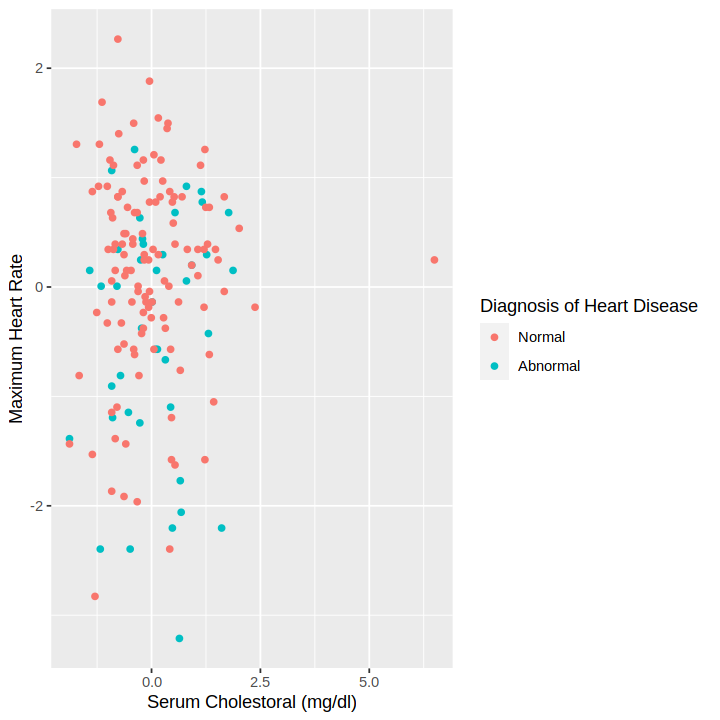

In [186]:
#PLot the Serum Cholestoral (mg/dl) vs. Maximum Heart Rate using scatter plot after scale
diagnosis_plot_s2 <- cleveland_scaled |>
    ggplot(aes(x=chol, y=thalach, color=num)) +
    geom_point() +
    labs(x = "Serum Cholestoral (mg/dl)", y = "Maximum Heart Rate", color = "Diagnosis of Heart Disease") +
    scale_fill_distiller(palette="Spectral")
diagnosis_plot_s2

## Methods

- Variables Used: age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope,ca, thal, num (as listed and explained at the start of the code).

- We selected the variables based on the ones we can best understand in the context of heart disease, as well as values we felt were best connected and could be used to answer our question.

- Using classification, we will find trends in certain sets of variables that show a high probability of heart disease by, firstly, testing the model, then using testing data to confirm the probabilities.

- We will either use scatter plots of variables compared to each other, with the colour being the diagnosis, or boxplots (the diagnosis of heart disease vs. the variables).

## Expected outcomes and significance

- What do you expect to find?

We are expecting to find a set of variables that contribute the most to the outcome of a prediction model. In other words, which combination of values (of the chosen variables) is linked to the highest chances of heart disease?


- What impact could such findings have?

These findings will help us understand what to do to lessen the chances of heart disease by managing and minimizing risk factors. It will also help us identify individuals at higher risk of heart disease and try to prevent the disease.


- What future questions could this lead to?

Are these issues or variables that increase the chances of heart disease hereditary, or can they be avoided? 
If so, what actions or steps can be taken to decrease the chances of heart disease?
Are there other risk factors not yet considered? Psychological risk factors?


## Reference

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.